AirBnB data for predicting the country of first destination is readily
available online (Kaggle). Can this same data be used to define/solve 
other business problems or create new opportunities?

One idea for this project is to create a seperate business case (project) using the same data. 

<p><b>Business case (project):</b></p>

<b>Note: This analysis does not include any 2020 data. Revenue projections were limited to the US</b>

Project: Days until revenue collected (days until first booking) and sizing the revenue opportunity (US).

An approximate 50% conversion rate US and global customers.
Revenue collected in 6 months for new customers (kaggle data) - \$0.21M (US) and \$1M (global).
Annual revenue collected for new customers (AirBnB real world data) - \$3.8 billions and $14.8 billions
Increasing conversion rates from 50% to 65% can lead to increase in \$1 billion (US only) in revenue.

The main observations from this project are:
    1. Missing values can skew the results
    2. Finding a way to change the number of variables (bias) and 
    observations (variance) with limited project resources
    3. Choice of model and metric using nonlinear algorithms
    4. How to handle unexpected results
        i. Transform output variable
        ii. Parameter tuning
Source: Statista and iProperty Management

In [698]:
###### from pyspark import SparkContext
#import pyspark.sql #import SparkSession
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import os
#import rpy2 
#import rpy2.robjects.packages as packages
#import rpy2.robjects.lib.ggplot2 as ggplot2
#import rpy2.robjects as ro
import math
import numpy as np
import pandas as pd
import pickle
#import blaze as bz
import pyspark as py
from time import time
from collections import Counter
import statsmodels as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as ss
from scipy.sparse import csc_matrix
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import RDD
from pyspark.sql.types import Row
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameReader
from pyspark.sql import DataFrameWriter
from pyspark.sql import types
from pyspark.sql.types import StructType, IntegerType, StringType, DecimalType
from pyspark.sql import DataFrameNaFunctions, \
DataFrameStatFunctions as statFunc
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.mllib.clustering import LDA
from sklearn import preprocessing 
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.classification import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
#import mongodb.jdbc.MongoDriver

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sb

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Panel, LabelSet
from bokeh.transform import factor_cmap, jitter
from bokeh.palettes import Paired12, Spectral6, Viridis3

# plotnine import *

#Display bokeh graphis in a notebook
output_notebook()

Loading BokehJS ...

In [699]:
#os.environ["CLASSPATH"]
#os.environ['PYSPARK_SUBMIT_ARGS'] = "--master=local[3] pyspark-shell"
os.environ['JAVA_HOME'] = "C:\\Program Files\\Java\\jdk1.8.0_191"

In [700]:
conf = SparkConf().set("spark.home", "C:\\MathLabASUS\\SW\\DM\\spark-2.4.0-bin-hadoop2.7") \
.set("spark.driver.extraClasspath", "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1") \
.set("spark.driver.extraClasspath", "org.mongodb:mongo-java-driver:3.9.0") \
.set("spark.submit.deployMode", "client") \
.set("spark.driver.memory", "5G") \
.set("spark.driver.maxResultSize", "5G") \
#.set("spark.mongodb.input.uri", "mongodb://127.0.0.1/ryerson.ferguson24?readPreference=primaryPreferred") \
#.set("spark.mongodb.output.uri", "mongodb://127.0.0.1/ryerson.ferguson24") 

In [701]:
sc = py.SparkContext("local[1]", conf=conf)

sc.stop()

In [702]:
sqlContext = SQLContext(sc)

s1 =SparkSession.builder.config(conf=SparkConf())
sc.getConf()

In [703]:
os.getcwd()

'C:\\MathLabASUS\\Projects\\Kaggle\\AirBnB\\airbnb_kaggle'

The project can be divided into three categories of data:
    1. Session - "search" pages, time
    2. Demographics - age, gender
    3. Website - ads, devices, apps

In [ ]:
### Session

In [704]:
session_df = sqlContext.read.csv("sessions.csv", \
                    header = True, mode = "DROPMALFORMED")

In [705]:
### Fill in missing values for categorical and numerical columns

In [706]:
session_df[["action", "action_type", "action_detail", "device_type"]].fillna("None")

DataFrame[action: string, action_type: string, action_detail: string, device_type: string]

In [707]:
##### Save session as a spark table

In [708]:
session_df.registerTempTable("session_df")

In [709]:
#### Define user actions in a session

In [710]:
%%time
action_df = sqlContext.sql("SELECT action, AVG(secs_elapsed) AS mean_secs FROM \
            session_df \
            GROUP BY action \
          ")
action_df = action_df.withColumn("mean_mins", col("mean_secs")/float(60.0))

Wall time: 18.5 ms


In [711]:
##### Distribution of time spent in minutes in an airbnb session

In [712]:
hist, edges = np.histogram(action_df.toPandas()["mean_mins"], density = True, \
                           bins = "auto")

In [713]:
output_notebook()
#bokeh.io.output_notebook()

session_data = ColumnDataSource(data = action_df.toPandas())
plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)#, Tooltips = tooltips)
plot.quad(bottom=0, top = hist, left = edges[:-1], \
          right = edges[1:], \
          fill_color = "blue", line_color = "white", alpha = 0.8, \
         hover_fill_color = "green")
plot.title.text = 'Distribution of time spent on airbnb (in a session)'
plot.xaxis.axis_label = 'Average time (minutes)'
plot.yaxis.axis_label = 'Frequency'
#plot.xaxis.major_label_orientation = 90
hover = HoverTool(tooltips = [('Frequency', '@{Frequency}{,}'), \
                              ('Average time (minutes)', '@hist'), ]) #('Frequency', '@Frequency')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

Most user actions on the website take less than 5,000 minutes. In fact anything above 3,000 might be considered an outlier (visually). Most users probably leave the web browser open while engaging in other activities. 3-5 hours on average i each session is a bteer measure. Time spent (in minutes) does not seem useful at this stage. 

What type of activities do users engage in for these sessions?

In [714]:
#### Top 10 user actions in a session - time spent in minutes

In [715]:
### Descriptive statistics

In [716]:
action_df[["action", "mean_mins"]].sort(desc("mean_mins")).toPandas().head(10)

,action,mean_mins
0,new_session,17526.916667
1,locations,13461.991667
2,recommend,8635.666667
3,10,6789.599218
4,12,6642.852737
5,set_password,5947.009748
6,payoneer_signup_complete,5218.083333
7,press_news,5055.350000
8,life,4913.033333
9,ajax_send_message,4829.912500


The time spent in by a user on a specific action appears to contain ouliers. Verify using some basic descriptive statistics.

In [717]:
##### Get mean, median and total values of time spent in a sesion (secs_elapsed)

In [718]:
session_df = session_df.withColumn("secs_elapsed", session_df["secs_elapsed"].cast(IntegerType()))

In [719]:
print("Mean time spent in user session (mins) = {}" .format(np.round(session_df.select("secs_elapsed").agg(avg(col("secs_elapsed"))).take(1)[0]["avg(secs_elapsed)"])))
print("Median time spent in user session (mins) = {}" .format(np.round(session_df.approxQuantile("secs_elapsed", [0.5], 0)[0])))

Mean time spent in user session (mins) = 21593.0
Median time spent in user session (mins) = 1314.0


The mean >> median. This implies that there are some large values 
(outliers) in the amount of time a user spends in a session. 

In [720]:
##### Remove ouliers

In [721]:
quantiles = action_df.toPandas().quantile([0.25, 0.75]).reset_index()
outlier_cutoff = quantiles.loc[1]["mean_mins"] + (1.5 * (quantiles.loc[1]["mean_mins"] - \
                                                    quantiles.loc[0]["mean_mins"]))

In [722]:
quantiles 

,index,mean_secs,mean_mins
0,0.25,12169.734148,202.828902
1,0.75,73306.333333,1221.772222


In [723]:
no_outlier_median = action_df.toPandas().quantile([0.50]).reset_index()
np.round(no_outlier_median, 2)

,index,mean_secs,mean_mins
0,0.5,31521.2,525.35


Users on average spend less than 10 hours in a session. The average is less than half once outliers are removed.

In [724]:
##### Top 10 actions by AirBnB users - outliers removed

In [725]:
%%time
action_df_no_outliers = action_df.filter(col("mean_mins") <= \
                                         outlier_cutoff).sort(desc("mean_mins"))
action_df_no_outliers_top10 = sqlContext.createDataFrame(action_df_no_outliers.head(10))

Wall time: 6.27 s


In [726]:
action_pd_df_10 = action_df_no_outliers.sort(desc("mean_mins")).toPandas()
action_pd_df_10["mean_mins"] = np.round(action_pd_df_10["mean_mins"])#[["action", "mean_mins"]]
action_pd_df_10[["action", "mean_mins"]].head(10)

,action,mean_mins
0,guest_booked_elsewhere,2629.0
1,salute,2593.0
2,concierge,2547.0
3,email_itinerary_colorbox,2439.0
4,upload,2361.0
5,receipt,2197.0
6,mobile_landing_page,2172.0
7,cancellation_policies,2156.0
8,other_hosting_reviews,2152.0
9,press_release,2080.0


The top 10 average time in a session per user action exceeds 35 hours

In [727]:
#### Get more details on user actions in a session

In [728]:
##### Calculate the average time spent during specific users action

In [729]:
session_group = Window().partitionBy("action", "action_type", "action_detail")
#median_udf = udf(lambda x: int(np.nanmedian(x)), IntegerType())
session_df = session_df.withColumn("secs_elapsed", \
                                   when(col("secs_elapsed").isNull(), \
                                        count(col("secs_elapsed")).over(session_group)).otherwise(col("secs_elapsed"))) 

In [730]:
##### Plot detailed user actions with outliers removed

In [731]:
### Find and plot top 10 user activities (action, type, and detail) by count and average minutes

In [732]:
%%time
user_activity_df = sqlContext.sql("SELECT action, action_type, \
                        action_detail, \
                        COUNT(action, action_type, action_detail) as count, \
                        PERCENTILE_APPROX(secs_elapsed, 0.5) AS avg_secs, \
                        PERCENTILE_APPROX(secs_elapsed, 0.5)/60 AS avg_mins \
                        FROM session_df \
                        GROUP BY action, action_type, action_detail \
          ")

Wall time: 14.4 ms


In [733]:
user_activity_df = user_activity_df.withColumn("activity", concat(lit("["), col("action"), lit(", "), col("action_type"), lit(", "), col("action_detail"), lit("]")))

In [734]:
##### Sort top 10 user activities by count

In [735]:
user_activity_pd_df = user_activity_df.select("activity", "count", "avg_mins").distinct().sort(desc("count")).toPandas() #.dropDuplicates(["activity", "mean_mins"]).collect()

In [736]:
user_activity_pd_df[["activity", "count", "avg_mins"]].sort_values("activity", ascending = True)

,activity,count,avg_mins
120,"[10, message_post, message_post]",213,4166.666667
172,"[11, message_post, message_post]",50,1003.450000
114,"[12, message_post, message_post]",274,3531.033333
143,"[15, message_post, message_post]",110,888.183333
229,"[about_us, -unknown-, -unknown-]",8,391.016667
...,...,...,...
299,None,0,62.016667
300,None,0,10.300000
301,None,0,69.450000
302,None,0,14.483333


In [737]:
user_activity_pd_df.count()

activity    293
count       304
avg_mins    304
dtype: int64

In [738]:
(user_activity_pd_df["activity"].str.match("") == True)

0       True
1       True
2       True
3       True
4       True
       ...  
299    False
300    False
301    False
302    False
303    False
Name: activity, Length: 304, dtype: bool

In [739]:
user_activity_pd_df = user_activity_df.toPandas().sort_values("avg_mins", ascending = False)
user_activity_pd_df["avg_mins"] = np.round(user_activity_pd_df["avg_mins"])
user_activity_pd_df[["activity", "count", "avg_mins"]].head(10)

,activity,count,avg_mins
247,"[new_session, -unknown-, -unknown-]",1,17527.0
129,"[recommend, -unknown-, -unknown-]",73,7027.0
86,"[life, -unknown-, -unknown-]",1,4913.0
81,"[payoneer_signup_complete, -unknown-, -unknown-]",5,4659.0
156,"[10, message_post, message_post]",213,4167.0
106,"[12, message_post, message_post]",274,3531.0
55,"[set_password, submit, set_password]",54,3222.0
17,"[locations, -unknown-, -unknown-]",2,3006.0
249,"[ajax_send_message, -unknown-, -unknown-]",4,3002.0
181,"[show, view, alteration_request]",4,2740.0


In [740]:
user_activity_pd_df.quantile(0.25)
user_activity_quantiles = user_activity_pd_df.quantile([0.25, 0.75]).reset_index()
user_activity_outlier_cutoff = user_activity_quantiles.loc[1]["avg_mins"] + (1.5 * (user_activity_quantiles.loc[1]["avg_mins"] - \
                                                   user_activity_quantiles.loc[0]["avg_mins"]))

In [741]:
user_activity_quantiles_no_outliers = user_activity_pd_df[user_activity_pd_df["avg_mins"] <= user_activity_outlier_cutoff].sort_values("avg_mins", ascending = False)


In [742]:
user_activity_quantiles_no_outliers[["activity", "count", "avg_mins"]].head(10) #_no_outliers.head()

,activity,count,avg_mins
238,"[onenight, -unknown-, -unknown-]",10,1104.0
18,"[concierge, -unknown-, -unknown-]",47,1090.0
269,"[approve, -unknown-, -unknown-]",1,1066.0
184,"[press_release, -unknown-, -unknown-]",21,1045.0
136,"[rentals, -unknown-, -unknown-]",7,1004.0
240,"[11, message_post, message_post]",50,1003.0
0,"[maybe_information, message_post, message_post]",2,978.0
113,"[confirm_email, click, confirm_email_link]",7256,969.0
66,"[ajax_image_upload, -unknown-, -unknown-]",1550,955.0
19,"[webcam_upload, -unknown-, -unknown-]",84,938.0


Once outliers are removed, most customers or users spend 18 hours in various activities before booking - messages, email, concierge, image uploads.
**time in search, personalizing data and updating listings**

In [743]:
### Demographics and website

In [744]:
### Analyze train_user2 data

In [745]:
train_user_df = sqlContext.read.csv("train_users_2.csv", \
                    header = True, mode = "DROPMALFORMED")

In [746]:
train_user_df.count()

213451

In [747]:
#### Get an idea about age distribution before replacing null values

In [748]:
age_list = [val[0] for val in train_user_df.select(col("age")).collect()]

age_pd_df = pd.DataFrame(age_list, columns = ["age"])

age_pd_df.count()

age    125461
dtype: int64

In [749]:
#### Basic statistics about age

In [750]:
age_pd_df.dropna(subset = ["age"], inplace = True)

age_hist = age_pd_df.groupby("age").size().reset_index(name = "count")
age_hist["age"] = age_hist["age"].astype(float)

#output_notebook()
output_notebook()

session_data = ColumnDataSource(data = age_hist)

age = session_data.data['age'].tolist()
#color_map = factor_cmap(field_name='age', palette=Paired12, \
 #                       factors = age)

plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)#, Tooltips = tooltips)

plot.vbar(x = "age", bottom=0, top='count', source = session_data, \
          width = 0.9, fill_color = "blue")

plot.title.text = 'Age distribution of AiBnB customers'
plot.xaxis.axis_label = 'Age'
plot.yaxis.axis_label = 'Count'
plot.xaxis.major_label_orientation = 90

hover = HoverTool(tooltips = [('Age', '@age'), ('Count', '@count')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

Some incorrect values for age 105 and over. Remove these errors or ouliers

In [751]:
age_pd_df = age_pd_df[age_pd_df["age"].astype(int) <= 105]
age_hist = age_pd_df.groupby("age").size().reset_index(name = "count")
age_hist["age"] = age_hist["age"].astype(float)

In [752]:
age_hist["age"].describe()

count     95.000000
mean      57.600000
std       28.293447
min        1.000000
25%       34.500000
50%       58.000000
75%       81.500000
max      105.000000
Name: age, dtype: float64

In [753]:
#output_notebook()
output_notebook()

session_data = ColumnDataSource(data = age_hist)

plot = figure(plot_width=750, plot_height = 400, \
              min_border = 0)#, Tooltips = tooltips)

plot.vbar(x = "age", bottom=0, top='count', source = session_data, \
          width = 0.9, fill_color = "blue")

plot.title.text = '60.0% of AirBnB are between 28 and 43 (working age)'
plot.xaxis.axis_label = 'Age'
plot.yaxis.axis_label = 'Count'
plot.xaxis.major_label_orientation = 90

hover = HoverTool(tooltips = [('Age', '@age'), ('Count', '@count')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

In [754]:
adult = np.sum(age_hist[(age_hist["age"] >= 18) & (age_hist["age"] <= 70)]["count"])/np.sum(age_hist["count"])
majority = np.round((np.sum(age_hist[(age_hist["age"] >= 28) & (age_hist["age"] <= 43)]["count"])/np.sum(age_hist["count"])), 1) * 100

In [755]:
print("{}% of AirBnB customers are between 28 and 43 (working age)" .format(majority))

60.0% of AirBnB customers are between 28 and 43 (working age)


In [756]:
#### Convert date columns to date types

In [757]:
train_user_df = train_user_df.withColumn("date_account_created", to_date("date_account_created", "yyyy-MM-dd"))
train_user_df = train_user_df.withColumn("date_first_booking", to_date("date_first_booking", "yyyy-MM-dd"))
train_user_df = train_user_df.withColumn("timestamp_first_active", to_timestamp(train_user_df.timestamp_first_active, "yyyyMMddHHmmss")).alias("timestamp_first_active")

In [758]:
train_user_df.registerTempTable("train_user_df")

In [759]:
##### Convert spark dataframe to pandas dataframe

In [760]:
train_user_pd_df = train_user_df.toPandas()

##### Placeholder to save train_user_pd_df dataframe

train_user_pd_df.to_csv("train_user_pd_df.csv", index = False)

##### Read the train_user pandas dataaframe file from csv

train_user_pd_df = pd.read_csv("train_user_pd_df.csv")

##### End of placehoder

##### Visualization of other variables

In [761]:
##### Customers to AirBnB website via signup partners

In [762]:
gender_by_signup_method = train_user_pd_df.set_index("gender", "signup_method").groupby(["gender", \
                                                                                         "signup_method"], as_index = False).size().reset_index(name = "size")#.fillna(0).reset_index(name = "size")

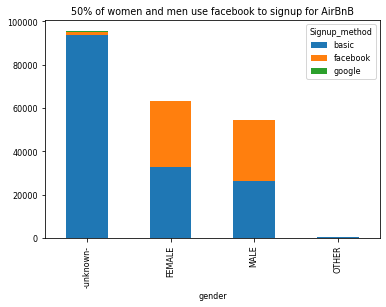

In [763]:
source_ct = pd.crosstab(gender_by_signup_method["gender"], gender_by_signup_method["signup_method"])
source_pt = gender_by_signup_method.pivot(index = "gender", \
                                    columns = "signup_method", \
                                   values = "size")
source_pt.plot.bar(stacked = True)
plt.title(label = "50% of women and men use facebook to signup for AirBnB")
plt.legend(title = "Signup_method")

In [764]:
##### Affiliate channels and providers used by customers

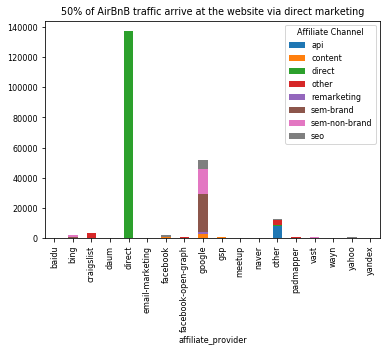

In [765]:
affiliate_provider_channel = train_user_pd_df.groupby(["affiliate_provider", \
                                                   "affiliate_channel"]).size().reset_index(name = "size")

affiliate_ct = pd.crosstab(affiliate_provider_channel["affiliate_provider"], affiliate_provider_channel["affiliate_channel"])
affiliate_pt = affiliate_provider_channel.pivot(index = "affiliate_provider", \
                                    columns = "affiliate_channel", \
                                   values = "size")
affiliate_pt.plot.bar(stacked = True)
plt.title(label = "50% of AirBnB traffic arrive at the website via direct marketing")
plt.legend(title = "Affiliate Channel")

Just under 50% of customers use direct marketing providers and channels.

In [766]:
##### Customer user exoerience - device type and signup app

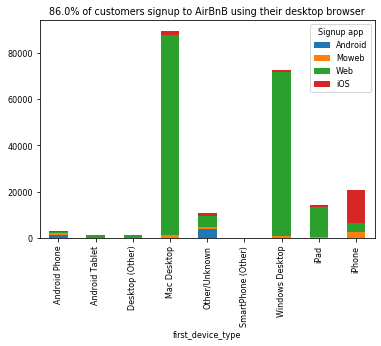

In [767]:
device_type_signupapp = train_user_pd_df.groupby(["first_device_type", \
                                                   "signup_app"]).size().reset_index(name = "size")

deviceapp_ct = pd.crosstab(device_type_signupapp["first_device_type"], device_type_signupapp["signup_app"])
deviceapp_pt = device_type_signupapp.pivot(index = "first_device_type", \
                                    columns = "signup_app", \
                                   values = "size")
deviceapp_pt.plot.bar(stacked = True)
plt.title(label = "86.0% of customers signup to AirBnB using their desktop browser")
plt.legend(title = "Signup app", \
           loc = "upper right")

In [768]:
device_and_signupapp = np.round((deviceapp_pt.iloc[3, 2] + deviceapp_pt.iloc[6, 2])/np.sum(deviceapp_pt)[2], 2) * 100
print("{}% of customers signup to AirBnB using their desktop browser" .format(device_and_signupapp))

86.0% of customers signup to AirBnB using their desktop browser


In [769]:
##### Affiliate marketing - first affiliate tracked

In [770]:
first_affiliate_pd_df = train_user_pd_df[["first_affiliate_tracked"]].dropna(subset = ["first_affiliate_tracked"])
first_affiliate_hist = first_affiliate_pd_df.groupby("first_affiliate_tracked").size().reset_index(name = "freq").sort_values("freq", ascending = False).reset_index()

In [771]:
first_affiliate_hist["first_affiliate_tracked"] = first_affiliate_hist["first_affiliate_tracked"].astype(str)
first_affiliate_hist["freq"] = first_affiliate_hist["freq"].astype(int)

In [772]:
first_affiliate_hist["perc"] = np.round((first_affiliate_hist["freq"])/np.sum(first_affiliate_hist["freq"]) * 100, 1)  

In [773]:
print("{} % of sales from affiliate marketing come from OMG and links" .format(np.round(np.sum(first_affiliate_hist["freq"][1:3])/np.sum(first_affiliate_hist["freq"]) * 100, 2)))

43.53 % of sales from affiliate marketing come from OMG and links


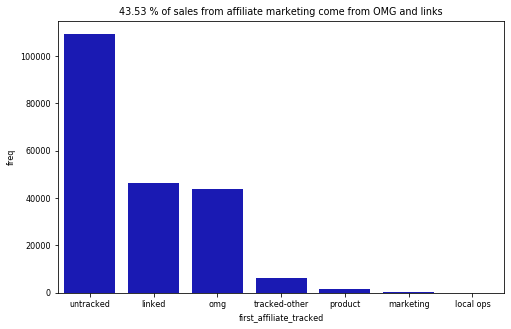

In [774]:
font = {"size": "8"}
plt.figure(figsize = (8,5))
plt.rc("font", **font)
sb.barplot(x = first_affiliate_hist["first_affiliate_tracked"], y = first_affiliate_hist["freq"], \
           color = "mediumblue", orient = "v")

plt.title("43.53 % of sales from affiliate marketing come from OMG and links")
plt.show()

In [775]:
##### Investigate relationship (multicollinearity) between categorical input variables

In [776]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    get_chisq = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = get_chisq/n
    r,k = confusion_matrix.shape
    phi2corr = np.max([0, phi2 - ((k-1)*(r-1))/(n-1)])
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    assoc_val  = np.sqrt(phi2corr/np.min([(kcorr-1), (rcorr-1)]))
    return assoc_val

In [777]:
def assoc_matrix(get_df, cat_columns):

    # Create dataframe of zeros
    assoc_matrix = pd.DataFrame(np.zeros((len(cat_columns), len(cat_columns))), \
                                         index = cat_columns, columns = cat_columns)

    # Get cramersv association matrix (value) and store in dataframe cell


    for col1 in cat_columns:
        for col2 in cat_columns:
            if col1 == col2:
                assoc_matrix[col1][col2] = 1.0
            else:
                assoc_matrix[col1][col2] = cramers_v(get_df[col1], get_df[col2])
    return assoc_matrix

In [778]:
cat_columns =["gender", "signup_method", \
              "signup_flow", 
              "language", \
              "affiliate_channel", 
              "affiliate_provider", \
              "first_affiliate_tracked", \
              "signup_app", "first_device_type", "first_browser", \
              "country_destination"]

In [779]:
assoc_matrix_all = assoc_matrix(train_user_pd_df, cat_columns)

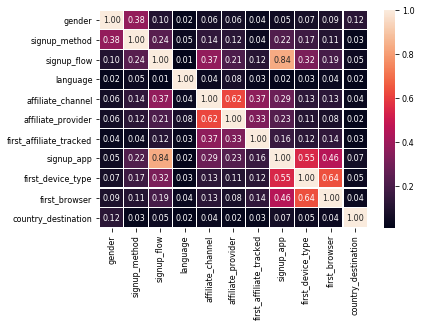

In [780]:
font = {"size": "8"}
plt.figure()
plt.rc("font", **font)
sb.heatmap(assoc_matrix_all, annot = True, fmt = ".2f", linewidth = 0.2, linecolor = "white" )
plt.show()

In [781]:
################################################################

In [782]:
##### Limit customers to ages 18 to 105

In [783]:
train_user_pd_df.dropna(subset = ["age"], inplace = True)
train_user_pd_df["age"] = train_user_pd_df["age"].astype(int)
train_user_pd_df = train_user_pd_df[(train_user_pd_df["age"] >= 18) & (train_user_pd_df["age"] <= 105)]

In [784]:
train_user_pd_df["age"].describe()

count    124220.000000
mean         37.268403
std          13.484673
min          18.000000
25%          28.000000
50%          34.000000
75%          43.000000
max         105.000000
Name: age, dtype: float64

In [785]:
##### Create column for no. of days before first booking

train_user_pd_df.to_csv("train_users_pd_df.csv")

In [786]:
train_user_pd_df["date_account_created"] = pd.to_datetime(train_user_pd_df["date_account_created"], errors = "coerce")
train_user_pd_df["date_first_booking"] = pd.to_datetime(train_user_pd_df["date_first_booking"], errors = "coerce")
train_user_pd_df["timestamp_first_active"] = pd.to_datetime(train_user_pd_df["timestamp_first_active"], errors = "coerce")
train_user_pd_df["days_first_booking"] = (train_user_pd_df["date_first_booking"] - train_user_pd_df["date_account_created"]).dt.days
train_user_pd_df["days_first_booking_ts"] = ((train_user_pd_df["date_first_booking"] - train_user_pd_df["timestamp_first_active"]).dt.days)
#train_user_pd_df["days_first_booking_ts"] = ((train_user_pd_df["date_first_booking"] - train_user_pd_df["timestamp_first_active"]).dt.total_seconds())/(24*60*60)
#train_user_pd_df["days_first_booking_ts"] = np.round(train_user_pd_df["days_first_booking_ts"] * 2) / 2
train_user_pd_df[train_user_pd_df["days_first_booking"] < 0]["days_first_booking"].count()

26

Two days before first booking features were created. One based on date_account created and the other timestamp_first_active.
Days before first booking (based on account created) has around 26 erroneous values, i.e. no. of days < 0. 
If used in a model need to remove these rows.

##### Distribution of number of days until first booking (account created)

In [787]:
numdays = train_user_pd_df.groupby("days_first_booking").size().reset_index(name = "count")
numdays["days_first_booking"] = numdays["days_first_booking"].astype(int)
numdays = numdays[numdays["days_first_booking"] >= 0]

In [788]:
numdays["days_first_booking"].describe()

count    366.000000
mean     182.500000
std      105.799338
min        0.000000
25%       91.250000
50%      182.500000
75%      273.750000
max      365.000000
Name: days_first_booking, dtype: float64

In [789]:
#output_notebook()
output_notebook()

session_data = ColumnDataSource(data = numdays)

plot = figure(plot_width= 400, plot_height = 400, \
              min_border = 0)#, Tooltips = tooltips)

plot.vbar(x = "days_first_booking", bottom=0, top='count', source = session_data, \
          width = 0.9, fill_color = "blue")

plot.title.text = 'Distribution of days until first AirBnB booking'
plot.xaxis.axis_label = 'Days'
plot.yaxis.axis_label = 'Count'
plot.xaxis.major_label_orientation = 90

hover = HoverTool(tooltips = [('Days', '@days_first_booking'), ('Count', '@count')])
plot.add_tools(hover)

show(plot)

Loading BokehJS ...

##### Distribution of number of days until first booking (timestamp first active)

In [790]:
numdays_ts = train_user_pd_df.dropna(subset = ["days_first_booking_ts"])
#numdays_ts["days_first_booking_ts"] = np.round(numdays_ts["days_first_booking_ts"]* 2) / 2
numdays_ts = numdays_ts.groupby("days_first_booking_ts").size().reset_index(name = "count")
numdays_ts["days_first_booking_ts"] = numdays_ts["days_first_booking_ts"].astype(int)
numdays_ts = numdays_ts[numdays_ts["days_first_booking_ts"] >= 0]

quantiles_ts = numdays_ts.quantile([0.01, 0.99]).reset_index()
outlier_cutoff_ts = quantiles_ts.loc[1]["days_first_booking_ts"] \
+ (1.5 * (quantiles_ts.loc[1]["days_first_booking_ts"] - \
        quantiles_ts.loc[0]["days_first_booking_ts"]))

no_outlier_median_ts = numdays_ts.quantile([0.50]).reset_index()
#print("Average number of days before first booking = {}" .format(np.round(no_outlier_median_ts, 2)))
      
numdays_ts_no_outliers = numdays_ts[(numdays_ts["days_first_booking_ts"] >= \
                                    quantiles_ts.loc[0]["days_first_booking_ts"]) & \
                       (numdays_ts["days_first_booking_ts"] <= \
                        quantiles_ts.loc[1]["days_first_booking_ts"])]
      
numdays_ts_no_outliers_10 = numdays_ts_no_outliers.tail(10)
#print(numdays_ts_no_outliers_10)
numdays_ts_no_outliers.count()

In [791]:
#numdays_ts_no_outliers
numdays_ts

,days_first_booking_ts,count
1,0,10657
2,1,4827
3,2,2969
4,3,2196
5,4,1707
...,...,...
394,1042,1
395,1057,1
396,1152,1
397,1336,1


In [792]:
#numdays_ts = numdays_ts_no_outliers
numdays_ts["days_first_booking_ts"] = np.where(numdays_ts["days_first_booking_ts"] == 0, 0, \
                                                      np.sqrt(numdays_ts["days_first_booking_ts"]))

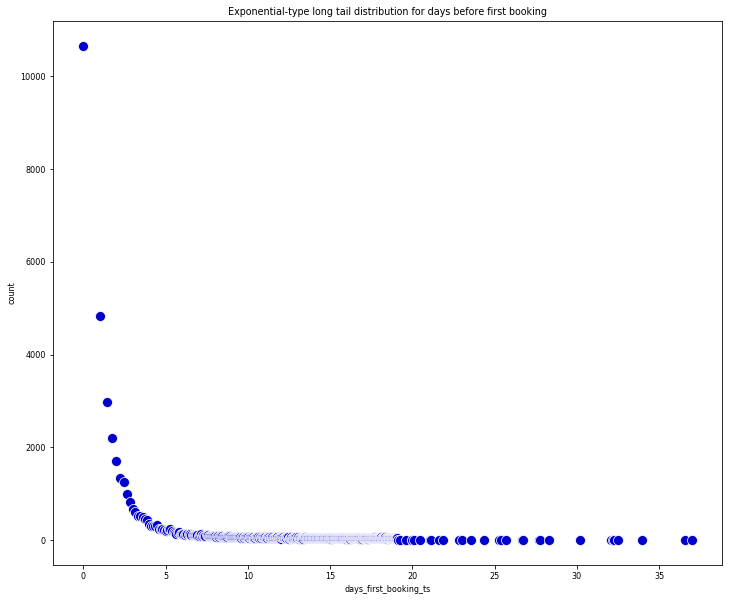

In [793]:
font = {"size": "8"}
plt.figure(figsize = (12,10))
plt.rc("font", **font)
sb.scatterplot(x = numdays_ts["days_first_booking_ts"], y = numdays_ts["count"], \
           color = "mediumblue", s = 100)

plt.title("Exponential-type long tail distribution for days before first booking")
#plt.xticks(ticks = np.arange(0, 500, step = 3
 #                            00), rotation = 90)
plt.show()

Days before first booking (account created and timestamp) has an exponoential or gamma long-tail distribution

In [794]:
numdays_ts.head()

,days_first_booking_ts,count
1,0.000000,10657
2,1.000000,4827
3,1.414214,2969
4,1.732051,2196
5,2.000000,1707


In [795]:
train_user_pd_df["days_first_booking_ts"] = \
train_user_pd_df["days_first_booking_ts"].astype(float)

##### Filter out all errorneous "days before first booking" values

In [796]:
#########################################################3

train_user_pd_df_ts = train_user_pd_df.dropna(subset = ["days_first_booking_ts"])
train_user_pd_df_ts = train_user_pd_df_ts[train_user_pd_df_ts["days_first_booking_ts"] >= 0]

train_user_pd_df_days = train_user_pd_df.dropna(subset = ["days_first_booking"])
train_user_pd_df_days = train_user_pd_df_days[train_user_pd_df_days["days_first_booking"] >= 0]

train_user_pd_df[train_user_pd_df["days_first_booking"].astype(float) >= 0].describe()

numdays_ts["days_first_booking_ts"].describe()

In [797]:
#############################################################

In [798]:
train_user_pd_df2 = train_user_pd_df[(train_user_pd_df["days_first_booking_ts"] >= 0) | (pd.isna(train_user_pd_df["days_first_booking_ts"]) == True)]

'''
train_user_pd_df = train_user_pd_df2[(train_user_pd_df2["days_first_booking_ts"] >= \
                                    quantiles_ts.loc[0]["days_first_booking_ts"]) & \
                       (train_user_pd_df2["days_first_booking_ts"] <= \
                        quantiles_ts.loc[1]["days_first_booking_ts"])]
 
'''
train_user_pd_df2["days_first_booking_ts2"] = np.where(train_user_pd_df2["days_first_booking_ts"] == 0, 0, \
                                                      np.sqrt(train_user_pd_df2["days_first_booking_ts"]))

In [799]:
train_user_pd_df2["days_first_booking_ts"].min()

0.0

In [800]:
##### End of EDA

In [801]:
#############################################################

Analyze train user data and link  to the sessio info

##### Train user data - fill in missing values and unknownd with the mean 

train_user_pd_df = pd.read_csv("train_user_pd_df.csv")

In [802]:
train_user_pd_df3 = train_user_pd_df2.drop(columns = ['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'days_first_booking', 'days_first_booking_ts'], axis = 1)

In [803]:
##### Create a boolean value to indicate if a customer makes a booking

In [804]:
train_user_pd_df3["booking"] = pd.isna(train_user_pd_df3["days_first_booking_ts2"])

In [805]:
 cat_columns =["gender", "signup_method", \
              "signup_flow", 
              "language", \
              "affiliate_channel", 
              "affiliate_provider", \
              "first_affiliate_tracked", \
              "signup_app", "first_device_type", "first_browser", \
              "country_destination"]

num_columns = ["age", "days_first_booking_ts2"]

In [806]:
countries_df = train_user_pd_df3.groupby("country_destination").size().reset_index(name = "count")
#countries_df["weights"] = countries_df["count"] / float(np.sum(countries_df["count"]))
#weights = train_user_pd_df3.merge(countries_df[["country_destination", "weights"]], on = "country_destination", how = "inner").reset_index()["weights"]

In [807]:
countries_df

,country_destination,count
0,AU,350
1,CA,834
2,DE,698
3,ES,1312
4,FR,3120
5,GB,1426
6,IT,1578
7,NDF,56154
8,NL,486
9,PT,121


In [808]:
def imputation_values(train_user_pd_df3, n_samples, size, \
                      cat_columns, num_columns, weights):
    

    X_imp = train_user_pd_df3

    ### Encode strings as integers

    X_imp.replace([np.nan, np.inf], 10000, inplace = True)

    X_imp = X_imp.astype(str)

   
    from sklearn import preprocessing

    labels_lst = []
    le = LabelEncoder()
    for col in X_imp.columns:
        le_array = le.fit_transform(X_imp[col])
        labels_lst.append(le_array)
        labels_np = np.transpose(np.array(labels_lst))
        
    labels_df = pd.DataFrame(labels_np, columns = X_imp.columns).reset_index()
    labels_df = labels_df.drop(num_columns, axis = 1).reset_index()
    #print(le.inverse_transform((list(np.round(labels_df["country_destination"].astype(int))))))
    
    ##### Merge all categorical and numerical dataframes
    
    num_df = X_imp[num_columns]
    num_df.replace([np.nan, np.inf, -np.inf], 10000, inplace = True)
    
    X_imp_df = labels_df.drop(columns = ["level_0"], axis = 1)
    
    X_imp_df[num_columns] =  num_df 
    X_imp_df.replace([np.nan, np.inf, -np.inf], 10000, inplace = True)
    
    ##### Convert all columns to numerical
    
    X_imp_df = X_imp_df.astype(float)
   
    X_imp_df = X_imp_df.drop(columns = ["index"], axis = 1)
    
    
    ###################################################################################
    
    
    ##### Use imputation to replace missing values (10,000)
    n = int(size * n_samples)
    
    impute_val = KNNImputer(missing_values = 10000, n_neighbors = n, \
                            weights = weights, copy = False)
    
    X_imp_df_samp = X_imp_df.sample(n = n_samples, axis = 0, \
                                    random_state = 20200131)
    
    knn_model = impute_val.fit_transform(X_imp_df_samp)
    
    ##### Placeholder to save KNN model

    pickle.dump(knn_model, open("knn_impute_model_test.sav", "wb"))

    with open("knn_impute_model_test.sav", "rb") as f:
        knn_model = pickle.load(f)

    ###############################################################################
    
    knn_imp_df = pd.DataFrame(knn_model.tolist(), columns = X_imp_df_samp.columns)
    knn_imp_df["index"] = X_imp_df_samp.index
    
    #x = le.fit_transform(knn_imp_df["country_destination"].astype(str))
    #knn_imp_df["country_destination_cat"] = le.inverse_transform((x))
    #print(knn_imp_df["country_destination_cat"])
    #knn_imp_df["country_destination_cat"] = le.inverse_transform(np.asarray(knn_imp_df["country_destination"].astype(int))) 
    
    '''
    knn_imp_df["age"] = np.floor(knn_imp_df["age"])
    '''
    return knn_imp_df, le

###### Create input and output features

In [809]:
def glm_model(X_imp_df):
    X = (X_imp_df.iloc[:, :-1])
    y = X_imp_df["days_first_booking_ts2"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size = 0.4, \
                                                       random_state = 20200116)

    #### Change model to Ensemble regression model

    train_const = sm.add_constant(X_train)

    tw_model = sm.GLM(y_train, exog = X_train, \
                      family = sm.families.Tweedie())

    tw_results = tw_model.fit()

    y_pred = tw_results.predict(X_test)

    print("MAD =", np.round(mean_absolute_error(y_test, y_pred), 2))

    print("Max error =", np.round(max_error(y_test, y_pred),2))

    print("RMSE =", np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
    
    print("Actual MAD = {} days" .format(np.round(mean_absolute_error(y_test, y_pred)**2, 2)))
    print("Actual RMSE = {} days" .format(np.round(np.sqrt(mean_squared_error(y_test, y_pred)))**2, 2))
    
    print("Median (average) = {} days" .format(np.round(np.median(y_test)**2, 2)))
    
    return

In [810]:
%%time
X_imp_df, label_enc = imputation_values(train_user_pd_df3, 30000, 1, \
                             cat_columns, num_columns, "uniform")

Wall time: 5min 36s


In [811]:
glm_model(X_imp_df)

MAD = 0.86
Max error = 82.76
RMSE = 1.56
Actual MAD = 0.74 days
Actual RMSE = 4.0 days
Median (average) = 27.62 days


On average the long-tailed tweedie model predicts it takes 27.62 days for a customer to make a booking with an error or mean average deviation (MAD) of less than one day (0.74)

In [812]:
#####  Scale numeric column age

In [813]:
scale = preprocessing.MinMaxScaler()
train_user_numcols = scale.fit_transform(train_user_pd_df3[["age"]])
numcols = pd.DataFrame(train_user_numcols, columns = ["age"]).reset_index()#X_imp_df2["age"] = numcols["age"]
train_user_pd_df3_scale = train_user_pd_df3
train_user_pd_df3_scale["age"] = numcols["age"]

In [814]:
%%time
X_imp_df_scale, label_enc = imputation_values(train_user_pd_df3_scale, 30000, 1, \
                             cat_columns, num_columns, "uniform")

Wall time: 3min 45s


In [815]:
glm_model(X_imp_df_scale)

MAD = 0.87
Max error = 86.2
RMSE = 1.61
Actual MAD = 0.76 days
Actual RMSE = 4.0 days
Median (average) = 27.62 days


MAD remains 0.76 when the numerical variables are scaled. 

Any possible improvements to the model can be made using various techniques:
    1. Feature selection
    2. Choice of model
    3. Sample size

##### Feature selection using anova

In [167]:
train_user_pd_df4.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,days_first_booking_ts2,booking
1,MALE,0.275862,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,10000.000000,True
2,FEMALE,0.264368,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,20.445048,False
3,FEMALE,0.321839,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,32.280025,False
4,-unknown-,0.367816,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,8.426150,False
6,FEMALE,0.333333,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,1.414214,False


In [433]:
train_user_pd_df4 = train_user_pd_df3_scale

Stats info

The GLM Tweedie model migh not be the best choice. Further improvements in the results might lie in changing to a different model or non-linear algorithm. An ensembe decision tree is chosen due to ease of use and smaller dataset compared to a neural network.

In [111]:
##### Change model to GradientBoost (decision tree ensemble)

Important for ensembles is tuning the maximum depth parameter.

In [816]:
maxdepth = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]
    

In [1318]:
def gdb_tuning_maxdepth(maxdepth, X_imp_df):
    gdb_md_trainscore = []
    gdb_md_testscore = []
    
    X = (X_imp_df.iloc[:, :-1])
    y = X_imp_df["days_first_booking_ts2"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size = 0.4, \
                                                       random_state = 20200116)

    
    for md in maxdepth:
        gdb_imp_scale = GradientBoostingRegressor(loss = "lad", \
                                           n_estimators = 500, \
                                           max_depth = md, \
                                          min_samples_split = 20, \
                                              random_state = 20200116, \
                                              max_features = "sqrt"
                                              )
        gdb_results_md = gdb_imp_scale.fit(X_train, y_train)
        gdb_md_trainscore.append(np.mean(gdb_results_md.train_score_))
        gdb_md_testscore.append((gdb_results_md.loss_(y_test, \
                                                             gdb_results_md.predict(X_test))))
    gdb_md = pd.DataFrame(
    {
        "max_depth": maxdepth,
        "train_score": gdb_md_trainscore,
        "test_score": gdb_md_testscore
    }

    )
    return gdb_md


In [1319]:
%%time
maxdepth_df = gdb_tuning_maxdepth(maxdepth, X_imp_df_scale)

Wall time: 5h 17min 16s


In [1320]:
maxdepth_df

,max_depth,train_score,test_score
0,2,0.696041,0.656360
1,3,0.578124,0.372767
2,4,0.233623,0.049558
3,5,0.273256,0.057166
4,8,0.132040,0.051950
5,10,0.090993,0.064888
6,15,0.059424,0.088746
7,20,0.053356,0.090189
8,25,0.053266,0.109750
9,30,0.049351,0.094983


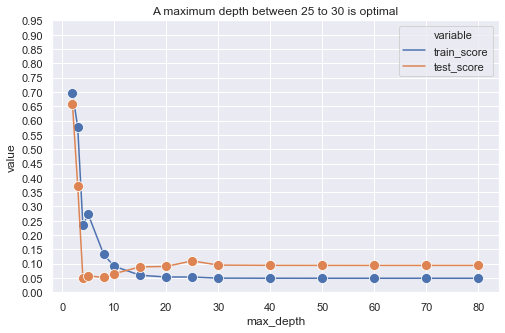

In [1325]:
font = {"size": "10"}
plt.figure(figsize = (8,5))
plt.rc("font", **font)
sb.lineplot(x = "max_depth", y = "value", hue = "variable", \
           data = pd.melt(maxdepth_df, ["max_depth"]), marker = "o", markersize = 10)

plt.title("A maximum depth between 25 to 30 is optimal")
plt.yticks(ticks = np.arange(0, 1, step = 0.05))
  
plt.show()

The optimal maximum depth paramter is for the training set, but is not stable for test set.
It seemsto stabilise at 30 for both the train and test set

In [818]:
def gdb_model(X_imp_df, md):
   
    maxdepth = md
    X = (X_imp_df.iloc[:, :-1])
    y = X_imp_df["days_first_booking_ts2"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size = 0.4, \
                                                       random_state = 20200116)
    gdb = GradientBoostingRegressor(loss = "lad", \
                                           n_estimators = 500, \
                                           max_depth = maxdepth, \
                                          min_samples_split = 20, \
                                              random_state = 20200116, \
                                              max_features = "sqrt"
                                              )
    gdb_results_md = gdb.fit(X_train, y_train)
    train_score = np.mean(gdb_results_md.train_score_)
    max_error_score = np.max(gdb_results_md.loss_(y_test, gdb_results_md.predict(X_test)))
    test_score = gdb_results_md.loss_(y_test, gdb_results_md.predict(X_test))
     
    MAD_trainscore = np.round(train_score, 2)
    MAD_testscore = np.round(test_score, 2)
    Max_error = np.round(max_error_score, 2)
    Actual_MAD_trainscore = np.round(train_score**2, 2)
    Actual_MAD_testscore = np.round(test_score**2, 2)
    Median = np.round(np.median(gdb_results_md.predict(X_test))**2, 2)
    
    
    gdb_md = pd.DataFrame({
    "metrics": [MAD_trainscore, MAD_testscore, Max_error, \
                Actual_MAD_trainscore, Actual_MAD_testscore, \
               Median]
    
    })
    gdb_md.index = ["MAD_trainscore", "MAD_testscore", "Max_error", \
                "Actual_MAD_trainscore", "Actual_MAD_testscore", \
                    "Median"]
    
    return gdb_md


In [819]:
%%time
gdb_model(X_imp_df_scale, 30)

Wall time: 3min 16s


,metrics
MAD_trainscore,0.05
MAD_testscore,0.09
Max_error,0.09
Actual_MAD_trainscore,0.00
Actual_MAD_testscore,0.01
Median,27.62


The average days until first booking remains 27.62 days. The MAD (error) however decreases to 0.01 (from 0.76)

##### Increase the sample size to 50,000

In [389]:
%%time
X_imp_df_50k = imputation_values(train_user_pd_df3, 50000, 1, \
                             cat_columns, num_columns, weights = "uniform")

Wall time: 1h 2min 27s


In [391]:
%%time
gdb_model(X_imp_df_50k[0], 30)

Wall time: 3min 47s


,metrics
MAD_trainscore,1.05
MAD_testscore,1.58
Max_error,1.58
Actual_MAD_trainscore,1.11
Actual_MAD_testscore,2.50
Median,27.37


Further tuning of the findings improves the error (MAD)  to 2.15 days. However there is a tradeoff between this slight improvement of 9.5% and the time take to run the code (increaes from 3 minutes to 1.5 hours).

Other resources for large datasets are spark etc.

In [ ]:
30k, 40 -  0.9816539393120315, 1.1165663963139782
50k, sqrt0 - 

In [ ]:
##### Add the average time a user spends in a session

In [820]:
%%time
session_time_df = sqlContext.sql("SELECT user_id as id, \
                        COUNT(action) as num_sessions, \
                        ROUND(SUM(secs_elapsed)/60, 2) as total_mins, \
                        ROUND((SUM(secs_elapsed)/60)/COUNT(action), 2) as avg_mins_session, \
                        ROUND(PERCENTILE_APPROX(secs_elapsed, 0.5), 2) AS avg_secs, \
                        ROUND(PERCENTILE_APPROX(secs_elapsed, 0.5)/60, 2) AS avg_mins \
                        FROM session_df \
                        GROUP BY user_id \
          ")
session_time_pd_df = session_time_df.toPandas()

Wall time: 16 s


In [821]:
IQR = (1.5 * session_time_pd_df['avg_mins_session'].quantile(0.75)) - (1.5 * session_time_pd_df["avg_mins"].quantile(0.25)) 
outlier_cutoff_session_time = session_time_pd_df['avg_mins_session'].quantile(0.75) + IQR

In [822]:
max_time = session_time_pd_df['avg_mins_session'].quantile(0.90)
min_time = session_time_pd_df['avg_mins_session'].quantile(0.02)

In [823]:
session_time_pd_df_red = session_time_pd_df[(session_time_pd_df['avg_mins_session'] >= min_time) & \
                                                            (session_time_pd_df['avg_mins_session'] <= max_time)]

In [824]:
#session_time_pd_df_red = session_time_pd_df[session_time_pd_df['avg_mins_session'] <= outlier_cutoff_session_time]

train_user_pd_df5 = train_user_pd_df2.drop(columns = ['date_account_created', 'timestamp_first_active',
       'date_first_booking', 'days_first_booking', 'days_first_booking_ts'], axis = 1)

train_user_pd_df_session = train_user_pd_df5.merge(session_time_pd_df_red[["id", 'avg_mins_session']], on = "id", how = "inner").reset_index()

train_user_pd_df_session["id"] = train_user_pd_df_session["id"].astype(str)
session_time_pd_df_red["id"] = session_time_pd_df_red["id"].astype(str)

train_user_pd_df_session = train_user_pd_df_session.iloc[:, 2:]

In [825]:
train_user_pd_df_session.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,days_first_booking_ts2,avg_mins_session
0,MALE,62,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,1.414214,453.38
1,FEMALE,32,facebook,0,en,seo,google,linked,Web,iPad,Mobile Safari,US,2.236068,165.58
2,-unknown-,19,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Safari,other,18.330303,535.17
3,MALE,25,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN,135.42
4,FEMALE,32,facebook,0,en,direct,direct,untracked,Web,iPad,Mobile Safari,US,0.000000,874.30


In [826]:
session_data = session_time_pd_df_red[["avg_mins_session"]].astype(int)
sessions = session_data.groupby("avg_mins_session").size().reset_index(name = "count")
sessions["avg_mins_session"] = sessions["avg_mins_session"].astype(int)
sessions = sessions[sessions["avg_mins_session"] >= 0]

In [827]:
sessions["avg_mins_session"].describe()

count    1172.000000
mean      589.994027
std       342.171165
min         2.000000
25%       294.750000
50%       587.500000
75%       881.250000
max      1200.000000
Name: avg_mins_session, dtype: float64

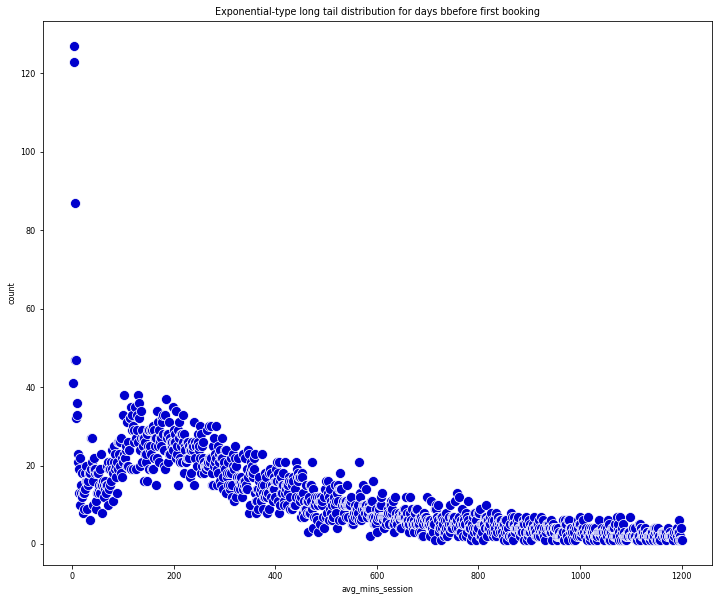

In [828]:
font = {"size": "8"}
plt.figure(figsize = (12,10))
plt.rc("font", **font)
sb.scatterplot(x = np.round(sessions["avg_mins_session"]), \
               y = sessions["count"], #data = sessions, \
           color = "mediumblue", s = 100)

plt.title("Exponential-type long tail distribution for days bbefore first booking")
#plt.xticks(ticks = np.arange(0, 500, step = 3
 #                            00), rotation = 90)
plt.show()

In [829]:
### Impact of no of days first booking on AirBnB 

In [830]:
 cat_columns =["gender", "signup_method", \
              "signup_flow", 
              "language", \
              "affiliate_channel", 
              "affiliate_provider", \
              "first_affiliate_tracked", \
              "signup_app", "first_device_type", "first_browser", \
              "country_destination"]

num_columns = ["age", "avg_mins_session", "days_first_booking_ts2"]

def encode_values(train_user_pd_df3, cat_columns, num_columns):
    

    X_imp = train_user_pd_df3

    ### Encode strings as integers

    X_imp = X_imp.astype(str)

   
    from sklearn import preprocessing

    labels_lst = []
    le = LabelEncoder()
    for col in X_imp.columns:
        le_array = le.fit_transform(X_imp[col])
        labels_lst.append(le_array)
        labels_np = np.transpose(np.array(labels_lst))
        
    labels_df = pd.DataFrame(labels_np, columns = X_imp.columns).reset_index()
    labels_df = labels_df.drop(num_columns, axis = 1).reset_index()
    #print(le.inverse_transform((list(np.round(labels_df["country_destination"].astype(int))))))
    
    ##### Merge all categorical and numerical dataframes
    
    num_df = X_imp[num_columns]
    
    X_imp_df = labels_df.drop(columns = ["level_0"], axis = 1)
    
    X_imp_df[num_columns] =  num_df 
    
    ##### Convert all columns to numerical
    
    X_imp_df = X_imp_df.astype(float)
   
    X_imp_df = X_imp_df.drop(columns = ["index"], axis = 1)
    
    
    ###################################################################################
    
    
    ##### Use imputation to replace missing values (10,000)
    return X_imp_df

In [831]:
%%time
X_imp_df_session, label_enc_session = imputation_values(train_user_pd_df_session, \
                                                        train_user_pd_df_session.count()[0], 1, \
                             cat_columns, num_columns, "uniform")

Wall time: 3.75 s


In [832]:
gdb_model(X_imp_df_session, 30)

,metrics
MAD_trainscore,0.07
MAD_testscore,0.20
Max_error,0.20
Actual_MAD_trainscore,0.01
Actual_MAD_testscore,0.04
Median,32.11


In [893]:
print("Average time a user spends in a session (hours)= {}" .format(np.round(np.median(X_imp_df_session["avg_mins_session"])/60, 1)))

Average time a user spends in a session (hours)= 4.5


In [ ]:
The average days until first booking increases to 32.11 days. The MAD (error) increases slightly to 0.04 (from 0.01).
Length of time a user spends in a session is an important feature in converting users to paying  customers

In [ ]:
##### Revenue dsta

1. Average no of nights = 5 
2. Average revenue per guests (US) = $185
3. Average revenue per guests (global) = $298.63
4. Average revenue per night (US) = $9.86M
5. Average no. of guests per night = 2 to 4
6. No. of guests per night = 2M

 A few key assumptions can be made. 
    1. Travellers book around 1 month ahead of arrival.
    2. Average no. of nights is for business trips, but used for all customer segments.
    3. Calculate US and "global" revenue
    4. Assume a random start date of April 1st. What counts is the days until first booking rather than the the actual start date.

In [ ]:
### Estimate revenue on users from the train set

In [833]:
def predict_days_gdb(X_imp_df, md):
   
    maxdepth = md
    X = X_imp_df.drop("days_first_booking_ts2", axis = "columns")
    y = X_imp_df["days_first_booking_ts2"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size = 0.4, \
                                                       random_state = 20200116)
    gdb = GradientBoostingRegressor(loss = "lad", \
                                           n_estimators = 500, \
                                           max_depth = maxdepth, \
                                          min_samples_split = 20, \
                                              random_state = 20200116, \
                                              max_features = "sqrt"
                                              )
    gdb_results_md = gdb.fit(X_train, y_train)
    predict_days = np.round(gdb_results_md.predict(X_test), 2)
    #print(X_test.columns) 
    predict_days_df = pd.DataFrame({
        "index": X_test["index"],
        "id": np.arange(X_test.shape[0]) + 1,
        "tf_days_first_booking": predict_days,
        "days_first_booking": predict_days**2,
        "booking": X_test["booking"],
        "country_destination": X_test["country_destination"]#,
       # "country_destination_cat": X_test["country_destination_cat"]
    })
    
    return predict_days_df
     

In [834]:
predict_days_df = predict_days_gdb(X_imp_df_scale, 30)

In [835]:
predict_days_df = predict_days_df[predict_days_df["days_first_booking"] >= 0]

print("{} days on average before customer makes their first booking" \
      .format(np.round(np.median(predict_days_df["days_first_booking"])), 2))

28.0 days on average before customer makes their first booking


In [836]:
predict_days_df["days_first_booking"].describe()

count    12000.000000
mean        27.073431
std         13.733947
min          0.012100
25%         21.529600
50%         27.562500
75%         28.090000
max        285.610000
Name: days_first_booking, dtype: float64

In [ ]:
In addition, the predicted days_first_booking contains a few outliers - where (predicted) days until first booking > 6 months.
The mean = median and 75% quantile approx equal median

In [ ]:
#### Revenue generated by new customers

In [ ]:
##### Create list of dates for timeframe - use random start date

In [837]:
def predict_dates(predict_days_df):
    start_date = pd.to_datetime("2020-04-01")#.strftime("%Y-%m-%d")
    predict_days_df["start_of_stay"] = start_date + \
    pd.to_timedelta(predict_days_df["days_first_booking"].astype(int), \
                    unit = "d") + pd.offsets.DateOffset(months = 1)
    predict_days_df["end_of_stay"] = predict_days_df["start_of_stay"] + \
    pd.to_timedelta(5, unit = "d")
    end_date = pd.to_datetime("2020-04-01") + pd.offsets.MonthEnd(6)
    for date in predict_days_df["end_of_stay"]:
        if (date <= end_date):
            predict_days_df["new_customer_bool"] = True
        else:
            predict_days_df["new_customer_bool"] = False
    
    return predict_days_df

In [838]:
predict_days_df2 = predict_dates(predict_days_df)

In [839]:
predict_days_df2.columns

Index(['index', 'id', 'tf_days_first_booking', 'days_first_booking', 'booking',
       'country_destination', 'start_of_stay', 'end_of_stay',
       'new_customer_bool'],
      dtype='object')

In [840]:
#### Transform country destinatio from numbers to country code

In [841]:
train_index_df = train_user_pd_df3_scale.index.to_frame()
train_index_df = train_index_df.rename(columns = {0: "index"})
train_index_df["country_destination_cat"] = train_user_pd_df3_scale["country_destination"]

In [842]:
predict_days_df2 = train_index_df.merge(predict_days_df2, on = "index", how = "inner").reset_index()

In [900]:
Average_revenue_per_guests_US = 185
Average_revenue_per_guests_global = 298.63
#Average_revenue_per_night = 80.67
#Average_no_of_guests_per_night_global = 2 * 1e6



In [933]:
np.sum(predict_days_df2[predict_days_df2["country_destination_cat"] == "US"]["new_customer_bool"])

2182

In [956]:
US_customers = predict_days_df2[predict_days_df2["country_destination_cat"] == "US"]
US_revenue = np.sum(US_customers["booking"].astype(int) * US_customers["new_customer_bool"].astype(int) * Average_revenue_per_guests_US)
Global_revenue = np.round(np.sum(predict_days_df2["booking"].astype(int) * predict_days_df2["new_customer_bool"].astype(int) * Average_revenue_per_guests_global)).astype(int)

In [957]:
print("Projected US revenue = {}" .format(US_revenue))
print("Projected Global revenue = {} " .format(Global_revenue))

Projected US revenue = 209420
Projected Global revenue = 999813 


Projected revenue (6 months) = $0.21M from approx. 2,200 US customers who book one month before their travel date, and $1M from 6,600 global customers.

In [ ]:
### Projected revenue based on AirBnB monthly traffic data

In [917]:
US_revenue_per_night = US_customers_perc * US_customers_convrate * Average_no_of_guests_per_night_global * Average_revenue_per_night

In [932]:
US_revenue_per_night

27697434.030937217

In [918]:
US_customers_perc = np.sum((predict_days_df2[predict_days_df2["country_destination_cat"] == "US"])["new_customer_bool"])/np.sum(predict_days_df2["new_customer_bool"])
US_customers_perc

0.33090688504701243

In [921]:
np.sum((predict_days_df2[predict_days_df2["country_destination_cat"] == "US"].count()[0]))/np.sum(predict_days_df2.count()[0])

0.33090688504701243

In [941]:
US_customers_book = np.sum(US_customers["booking"].astype(int) * US_customers["new_customer_bool"].astype(int))
US_customers_convrate = US_customers_book/US_customers.count()[0]
Global_customers_book = np.sum(predict_days_df2["booking"].astype(int) * predict_days_df2["new_customer_bool"].astype(int)) 
Global_customers_convrate = Global_customers_book/predict_days_df2.count()[0]

In [942]:
print("US conversion rates = {}%" .format(np.round(US_customers_convrate, 2) * 100))
print("Global conversion rates = {}%" .format(np.round(Global_customers_convrate, 2) * 100))

US conversion rates = 52.0%
Global conversion rates = 51.0%


In [ ]:
##### Real world non-revenue customer data - includes session data 

1. Average session time = 11 min 31 secs
2. Mobile traffic (% of app) = 50%
3. AirBnB users in the US (2017) = 33.9M
4. AirBnB users in the US (2020) = 40M
5. Percentage of AirBnB users (US 2018) = 41%



In [ ]:
#### Projected revenue based on AirBnB (actual) monthly dats

Monthly_traffic = 91 * 1e6 # (global) 
US_users = 0.41
US_traffic = US_customers_convrate * np.round(US_customers_book/Global_customers_book * Monthly_traffic) * US_revenue
Global_traffic = np.round(Global_customers_convrate * Monthly_traffic)# * Global_revenue

In [1002]:
US_users = 40 * 1e6 
US_users_perc = 0.41
Global_users = US_users/US_users_perc
Global_revenue_actual = np.round(Global_users * Global_customers_convrate * Average_revenue_per_guests_global/(1 * 1e9), 1)
US_revenue_actual = np.round(US_users * US_customers_convrate * Average_revenue_per_guests_US/(1 * 1e9), 1)

In [1003]:
print("Actual US revenue = ${}B" .format(np.round(US_revenue_actual, 1)))
print("Actual Global revenue = ${}B" .format(np.round(Global_revenue_actual, 1)))

Actual US revenue = $3.8B
Actual Global revenue = $14.8B


In [ ]:
#### Increasing revenue

Increase conversion rate or increase number of users.
E.g. Growing the US market by $1B. Increase conversion rate to 70% (change of +17%)

In [1006]:
print("Increase conversion rate to {}%" .format(np.round(((US_revenue_actual + 1) * 1*1e9)/(US_users * Average_revenue_per_guests_US) * 100)))

Increase conversion rate to 65.0%


In [1106]:
airbnb_revenue = pd.DataFrame(
    {
        
    "Type": ["US_revenue", "Global_revenue", "US_revenue_actual",\
            "GlobL_revenue_actual", "US_convrate", \
            "Global_convrate"],
    "Revenue": [US_revenue/1e6, Global_revenue/1e6, \
                US_revenue_actual, \
               Global_revenue_actual, US_customers_convrate, \
                Global_customers_convrate] 

}
).reset_index()
airbnb_revenue = airbnb_revenue.groupby(["Type"]).median().sort_values("index").reset_index()

In [1286]:
airbnb_revenue = pd.DataFrame(
    {
        
    "Type": ["US ($M)", "Global ($M)", "US ($B)", "Global ($B)", "US (%)", \
            "Global (%)"],
    "Revenue": [US_revenue/1e6, Global_revenue/1e6, \
                US_revenue_actual, \
               Global_revenue_actual, US_customers_convrate * 100, \
                Global_customers_convrate * 100] 
    
}
).reset_index()
airbnb_revenue["Revenue"] = np.round(airbnb_revenue["Revenue"], 2)
#airbnb_revenue = airbnb_revenue.groupby(["Type"]).median().sort_values("index").reset_index()

In [1287]:
airbnb_revenue

,index,Type,Revenue
0,0,US ($M),0.21
1,1,Global ($M),1.00
2,2,US ($B),3.80
3,3,Global ($B),14.80
4,4,US (%),51.88
5,5,Global (%),50.77


In [1288]:
airbnb_sample = airbnb_revenue[(airbnb_revenue["Type"] == "US ($M)") | (airbnb_revenue["Type"] == "Global ($M)")]
airbnb_actual = airbnb_revenue[(airbnb_revenue["Type"] == "US ($B)") | (airbnb_revenue["Type"] == "Global ($B)")]
airbnb_convrate = airbnb_revenue[(airbnb_revenue["Type"] == "US (%)") | (airbnb_revenue["Type"] == "Global (%)")]

Text(0.5, 0.98, 'AirBnB has US and global revenue (estimates) of \\$3.8 billion and \\$14.8 billion based on 50% customer conversion rates (2019)')

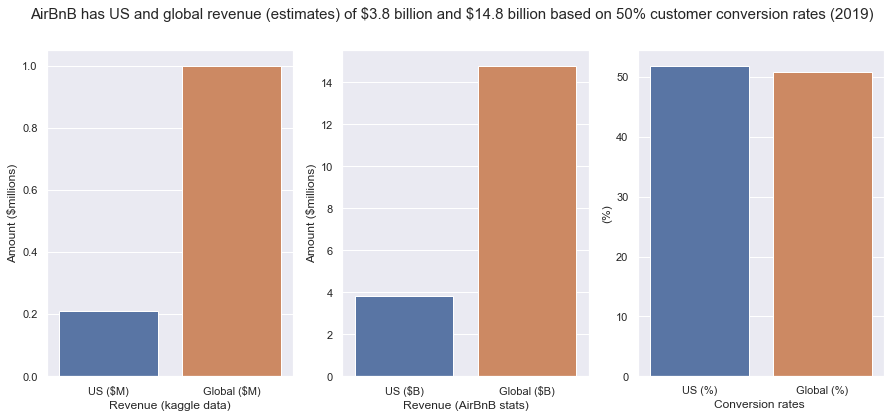

In [1324]:
fig, axs = plt.subplots(ncols = 3, figsize = (15, 6))
sb.set(font_scale = 1)
sb.barplot(x = "Type", y = "Revenue", data = airbnb_sample, ax = axs[0])
sb.barplot(x = "Type", y = "Revenue", data = airbnb_actual, ax = axs[1])
sb.barplot(x = "Type", y = "Revenue", data = airbnb_convrate, ax = axs[2])
axs[0].set_xlabel("Revenue (kaggle data)", fontsize = 12)
axs[0].set_ylabel("Amount ($millions)", fontsize = 12)
axs[1].set_xlabel("Revenue (AirBnB stats)", fontsize = 12)
axs[1].set_ylabel("Amount ($millions)", fontsize = 12)
axs[2].set_xlabel("Conversion rates ", fontsize = 12)
axs[2].set_ylabel("(%)", fontsize = 12)
fig.suptitle("AirBnB has US and global revenue (estimates) of \$3.8 billion and \$14.8 billion based on 50% customer conversion rates (2019)", \
            fontsize = 15)

In [ ]:
## Plot of projected AirBnB revenue growth 

Text(0.5, 0.98, 'AirBnB can increase their US revenue by $1 billion with a 15% growth in customer conversion rates')

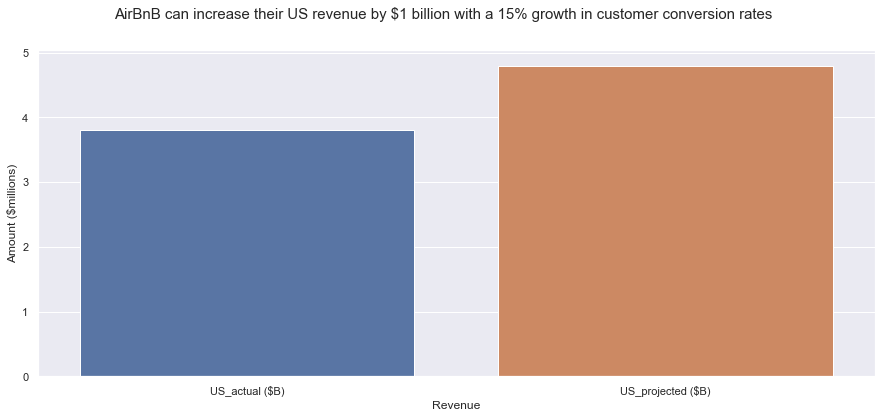

In [1314]:
airbnb_revenue_bc = pd.DataFrame(
    {
        
    "Type": ["US_actual ($B)", "US_projected ($B)"],
    "Revenue": [US_revenue_actual, (US_revenue_actual) + 1]
    
}
).reset_index()

airbnb_revenue_bc["Revenue"] = np.round(airbnb_revenue_bc["Revenue"], 2)
fig, axs = plt.subplots(ncols = 1, figsize = (15, 6))
sb.barplot(x = "Type", y = "Revenue", data = airbnb_revenue_bc, ax = axs)
sb.set(font_scale = 1)
axs.set_xlabel("Revenue", fontsize = 12)
axs.set_ylabel("Amount ($millions)", fontsize = 12)
fig.suptitle("AirBnB can increase their US revenue by $1 billion with a 15% growth in customer conversion rates", \
            fontsize = 15)

Opportunities exist for AirBnB to grow their market even in tough economic times. One such way is by increasing the number of customers booking accomodation from their existing customer/user based.
An increase in conversion rate of 15% can lead to revenue growth of $1B.
Note: This analysis does not include any 2020 data. It however can be used as a guideline for an additional company business case.